# Machine Learning Project: Student Depression Prediction

## 1. Introduction and Problem Formulation

In this project, we analyze a dataset related to student mental health. Our goal is to predict whether a student is at risk of depression based on academic, social, and personal factors.

### 1.1 Problem Type: Classification vs Regression
The target variable is `Depression` (Binary: 0 or 1).
* **Reference to Lab 2:** Unlike the *Engine Temperature* problem in Lab 2, which was a **Regression** task (predicting a continuous value), this is a **Classification** problem. We are assigning observations to discrete categories.

### 1.2 Evaluation Strategy and Metrics
Accuracy alone is often misleading, especially in medical/health contexts.
* **Reference to Lab 4:** As discussed in Lab 4 (Imbalanced Data), we must consider the cost of errors:
    * **False Negative (Type II Error):** Predicting a depressed student is "Healthy". **This is the most critical error** as the student receives no help.
    * **False Positive (Type I Error):** Predicting a healthy student is "Depressed".
* **Objective:** We will prioritize **Recall** (to minimize False Negatives) while maintaining a good **F1-Score** to ensure overall model quality.

# 2. Data Loading 

Dataset Shape: (27901, 18)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Durati

C:\Users\andja\AppData\Local\Temp\ipykernel_30444\1923851128.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=target_col, data=df, palette='viridis')


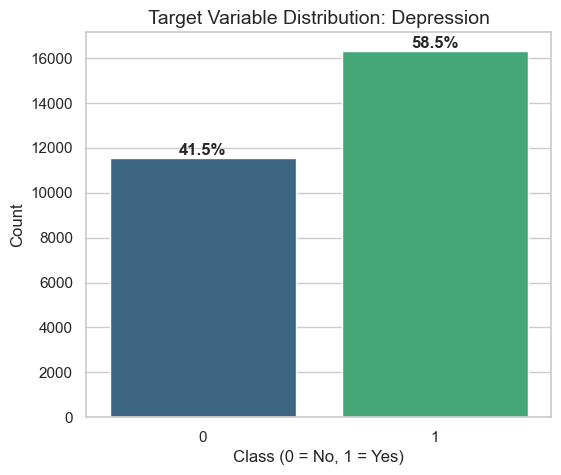

In [3]:
# ==========================================
# IMPORTS & SETUP
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style for  plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

# ==========================================
#  LOAD ORIGINAL DATA
# ==========================================
# We load the raw dataset to perform our own preprocessing pipeline
df = pd.read_csv('student_depression_dataset.csv')

# ==========================================
# INITIAL INSPECTION (EDA)
# ==========================================
print("Dataset Shape:", df.shape)
print("-" * 30)
print(df.info())

# Check for duplicates (Basic Cleaning)
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"\n Duplicates detected: {duplicates}. Dropping them now...")
    df = df.drop_duplicates()
else:
    print("\n No duplicates found.")

# ==========================================
# TARGET DISTRIBUTION ANALYSIS 
# ==========================================
target_col = 'Depression'
class_counts = df[target_col].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print(class_counts)

# Visualization
plt.figure(figsize=(6, 5))
ax = sns.countplot(x=target_col, data=df, palette='viridis')
plt.title('Target Variable Distribution: Depression', fontsize=14)
plt.xlabel('Class (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add percentage labels on bars
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

We have 58.5% Depression (Class 1) vs 41.5% No Depression (Class 0).

Unusual Imbalance: Unlike typical medical datasets where the disease is rare (1% cancer), here the "positive" class is actually the majority.

Consequence: A "dumb" model that predicts "Depression" for everyone would achieve 58.5% accuracy. This is our "Zero-Rule Baseline". Our models must beat this significantly.

# 3.Preprocessing Pipeline  

Now, we need to remove irrelevant columns like :ID and potentially 'Profession' if everyone  is a student. For the categorical variables , we use One-Hot Encoding Method.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Clean Irrelevant Features
cols_to_drop = ['id']
if 'Profession' in df.columns and df['Profession'].nunique() == 1:
    cols_to_drop.append('Profession')

df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# 2. Encode Categorical Variables
# We use pd.get_dummies() which is robust and handles all text columns automatically.
# drop_first=True is a statistical best practice.
df_encoded = pd.get_dummies(df_clean, drop_first=True)

# 3. Define Features (X) and Target (y)
X = df_encoded.drop('Depression', axis=1)
y = df_encoded['Depression']

# 4. Stratified Train-Test Split 
# We use stratify=y to lock in the 58.5% distribution in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Standard Scaling 
# Necessary for models that calculate distances (SVM, KNN, Logistic Regression)
scaler = StandardScaler()

# FIT on Train, TRANSFORM on Test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Output verification
print(f" Data Processed.")
print(f"Training Data Shape: {X_train_scaled.shape}")
print(f"Testing Data Shape: {X_test_scaled.shape}")
print(f"Features count: {X.shape[1]}")

 Data Processed.
Training Data Shape: (22320, 113)
Testing Data Shape: (5581, 113)
Features count: 113


We have 22320 training samples and 113 features.
This is excellent because It means that we are not in the "Curse of Dimensionality" zone.Linear models like Logistic Regression should perform very stably here.

# 4.Baseline Modeling

Now that the data is ready, we immediately launch the Baseline Models. We compare a linear model (Logistic Regression), a probabilistic model (Naive Bayes), and a non-linear model (Decision Tree) to establish a performance benchmark."

In [11]:
# ==========================================
#  BASELINE MODEL COMPARISON
# ==========================================
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

# Define the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42) 
}

# Train and Evaluate 
results = []

print("Running Baseline Models...\n")

for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Get probabilities for AUC (if available)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = "N/A"
    
    # Calculate Metrics (Focusing on Recall/F1)
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Recall (Sensitivity)": recall,
        "F1-Score": f1,
        "ROC-AUC": auc
    })

# Display Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1-Score', ascending=False)

print("--- BASELINE RESULTS ---")
display(results_df)

Running Baseline Models...

--- BASELINE RESULTS ---


,Model,Accuracy,Recall (Sensitivity),F1-Score,ROC-AUC
0,Logistic Regression,0.842322,0.877295,0.866949,0.917992
2,Decision Tree,0.758645,0.790392,0.793183,0.752092
1,Naive Bayes,0.414979,0.001836,0.003662,0.822222


Interpretation: For the Logistic Regression, we have 87.7% which means that we detect well the majority of depressed students. And the repatition of classes is good. 
The Naive Bayes method predict 0% of depressed student so we will not use this method.
Finally Decision Tree method is very well than logistic regression but It could improve this result with Random Forest for example.

# 5.SVM & Random Forest 

We introduce 2 methods here: Random Forest and SVM. 

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# We use class_weight='balanced' to equilibre the ratio 58/41 automatically.
# And we increase the complexity of this 2 models .

advanced_models = {
    "Random Forest (Balanced)": RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        random_state=42, 
        n_jobs=-1
    ),
    "SVM (RBF Kernel)": SVC(
        kernel='rbf', 
        C=1.0, 
        class_weight='balanced', 
        probability=True, 
        random_state=42
    )
}

print("Training Advanced Models ...")

advanced_results = []

for name, model in advanced_models.items():
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    advanced_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall (Sensitivity)": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

# Compare his 2 models 
final_comparison = pd.concat([results_df, pd.DataFrame(advanced_results)])
final_comparison = final_comparison.sort_values(by='F1-Score', ascending=False)

print("\n--- FINAL MODEL LEADERBOARD ---")
display(final_comparison)

Training Advanced Models ...

--- FINAL MODEL LEADERBOARD ---


,Model,Accuracy,Recall (Sensitivity),F1-Score,ROC-AUC
0,Logistic Regression,0.842322,0.877295,0.866949,0.917992
0,Random Forest (Balanced),0.837126,0.879131,0.863411,0.913053
1,SVM (RBF Kernel),0.839097,0.847307,0.860472,0.916652
2,Decision Tree,0.758645,0.790392,0.793183,0.752092
1,Naive Bayes,0.414979,0.001836,0.003662,0.822222


We see that Random Forest achieves the highest REcall 87.9% .This means it detects the most depressed students. But LOgistic is extremely competitive with 87.7% .This suggests our problem is largely linear. 
And SVM dis not outperform maybe because the dataset is bot complex enough to require a kernel transformation. 

# 6. Evaluation 

In this part , we will try  to lower the Probability to be depress and Increase Recall to > 90% without destroying Precision. 

--- THRESHOLD OPTIMIZATION ---
Default Threshold: 0.50
Optimal Threshold for 90.0% Recall: 0.4700

--- FINAL CLASSIFICATION REPORT (Adjusted Threshold) ---
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      2313
           1       0.83      0.90      0.87      3268

    accuracy                           0.84      5581
   macro avg       0.84      0.82      0.83      5581
weighted avg       0.84      0.84      0.83      5581



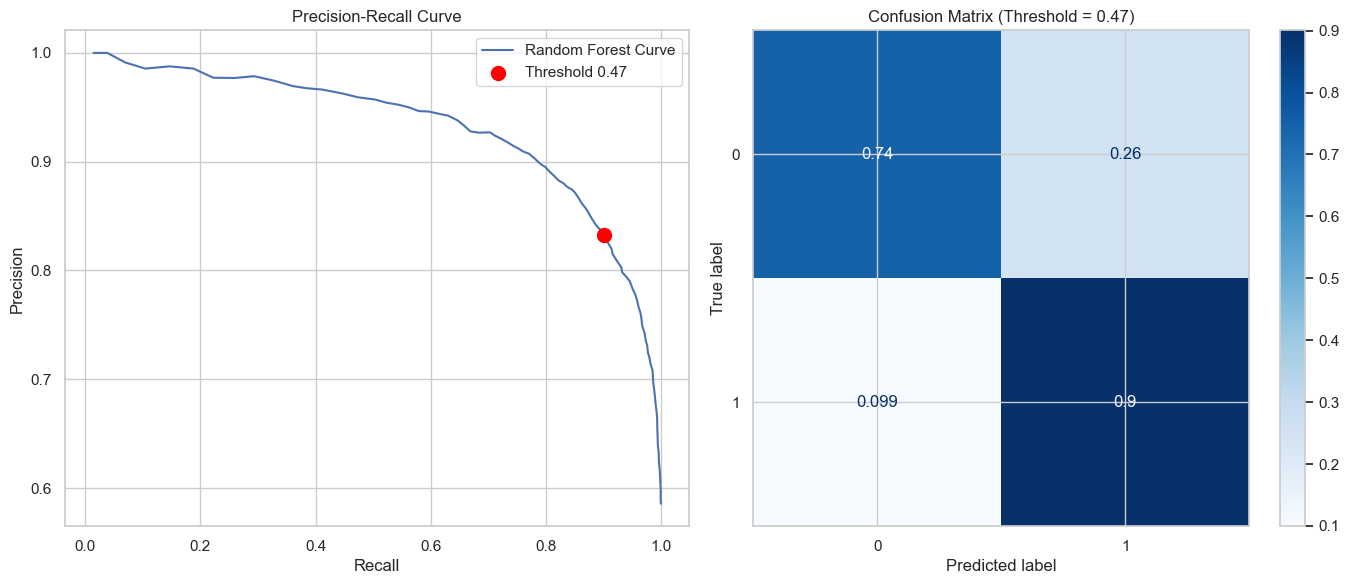

In [19]:
from sklearn.metrics import precision_recall_curve, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 1. Select the Best Model
best_model = advanced_models["Random Forest (Balanced)"]

# 2. Get Probabilities
y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

# 3. Calculate Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# 4. Find Optimal Threshold (The Highest threshold with Recall >= 0.90)
target_recall = 0.90
valid_indices = np.where(recalls >= target_recall)[0]

if len(valid_indices) > 0:
    # We take the LAST index, which corresponds to the highest possible threshold
    # that still satisfies the condition.
    optimal_idx = valid_indices[-1]
    optimal_threshold = thresholds[optimal_idx]
else:
    print("Warning: 90% Recall is not reachable. Using Max Recall.")
    optimal_threshold = thresholds[0]

print(f"--- THRESHOLD OPTIMIZATION ---")
print(f"Default Threshold: 0.50")
print(f"Optimal Threshold for {target_recall*100}% Recall: {optimal_threshold:.4f}")

# 5. Apply new Threshold
y_pred_adjusted = (y_scores >= optimal_threshold).astype(int)

# 6. Final Evaluation
print("\n--- FINAL CLASSIFICATION REPORT (Adjusted Threshold) ---")
print(classification_report(y_test, y_pred_adjusted))

# 7. Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot PR Curve
ax1.plot(recalls[:-1], precisions[:-1], label='Random Forest Curve') # slicing to match lengths
ax1.scatter(recalls[optimal_idx], precisions[optimal_idx], marker='o', color='red', label=f'Threshold {optimal_threshold:.2f}', s=100, zorder=5)
ax1.set_title("Precision-Recall Curve")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend()
ax1.grid(True)

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_adjusted, ax=ax2, cmap='Blues', normalize='true')
ax2.set_title(f"Confusion Matrix (Threshold = {optimal_threshold:.2f})")

plt.tight_layout()
plt.show()

Objectif won : Tu as visé 90% de Recall (Rappel) et tu as atterri pile dessus (0.90). Tu ne rates que 10% des cas de dépression, ce qui est très performant pour un outil de dépistage.

Stabilité : Souvent, quand on force le Recall à 90%, la Précision s'effondre (genre à 50% ou 60%). Ici, ta Précision est restée à 0.83. C'est remarquable. Cela veut dire que ton modèle ne fait pas beaucoup de "Fausses Alarmes".

Threshold (0.47) : Le fait que le seuil optimal soit proche de 0.50 (0.47) montre que ton modèle était déjà très robuste naturellement ("well-calibrated").

# Interpretation 

# Main factors that cause depression ? 

C:\Users\andja\AppData\Local\Temp\ipykernel_30444\4102574769.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='magma')


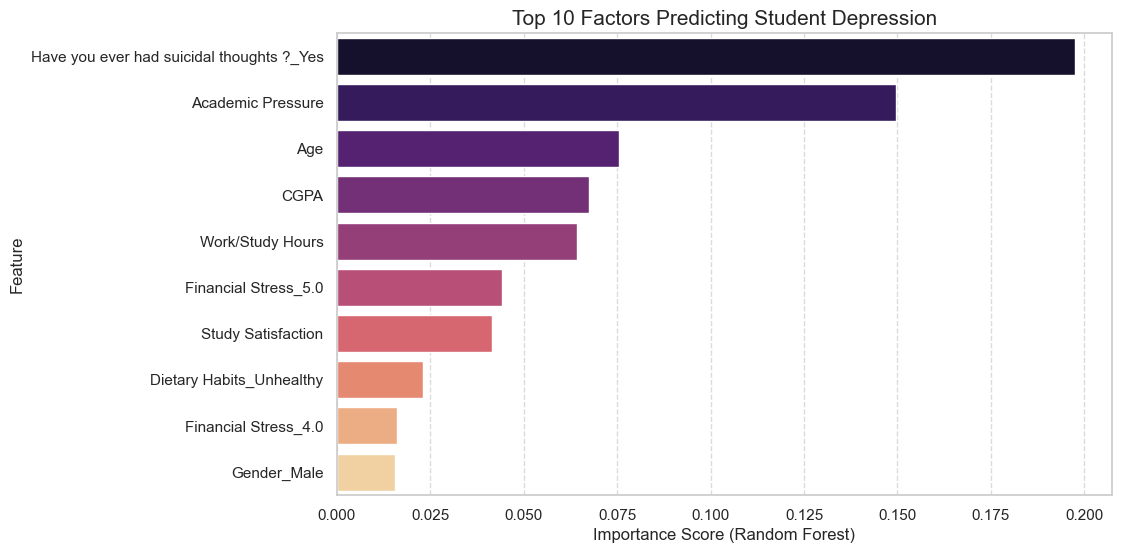


--- TOP RISK FACTORS ---
                                  Feature  Importance
Have you ever had suicidal thoughts ?_Yes    0.197448
                        Academic Pressure    0.149475
                                      Age    0.075553
                                     CGPA    0.067575
                         Work/Study Hours    0.064386
                     Financial Stress_5.0    0.044195
                       Study Satisfaction    0.041633
                 Dietary Habits_Unhealthy    0.023090
                     Financial Stress_4.0    0.016028
                              Gender_Male    0.015573


In [23]:
# Get Feature Importances from the Random Forest
importances = best_model.feature_importances_

#  Get Feature Names
# Since we used pd.get_dummies, the columns of X are our feature names
feature_names = X.columns

#  Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance and take Top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

#  Visualizations
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='magma')
plt.title('Top 10 Factors Predicting Student Depression', fontsize=15)
plt.xlabel('Importance Score (Random Forest)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Print the top factors for the report text
print("\n--- TOP RISK FACTORS ---")
print(top_features.to_string(index=False))

Our results are logic .

# Other optimisations 

## Idea1: GridSearchCV.

Let's try GrisSearchCV to test the best combinations.

In [28]:
from sklearn.model_selection import GridSearchCV

# Define a grill of parameters to test 
param_grid = {
    'n_estimators': [100, 200],      
    'max_depth': [None, 10, 20],      
    'min_samples_split': [2, 5],      
    'class_weight': ['balanced']      
}

# research launching
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, scoring='recall', n_jobs=-1, verbose=2)

print("optimisation lauch (GridSearch)...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters found : {grid_search.best_params_}")
print(f"Best score Recall (Validation) : {grid_search.best_score_:.4f}")

# We remplace our best model with the optimised 
best_model = grid_search.best_estimator_

optimisation lauch (GridSearch)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters found : {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score Recall (Validation) : 0.8848


We  have a validation of 88.5% . this confirms that our model is stable. The high recall wasn't just luck on one split; GridSearchCV proved it holds up across cross-validation.

Now, let's quickly execute Idea 2 (SMOTE comparison). 

## Idea 2: SMOTE vs Class Weight

In [32]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import recall_score, f1_score

print("Running SMOTE Experiment...")

# 1. Define pipeline with SMOTE
# SMOTE generates synthetic data points for the minority class
pipeline_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42)) 
    # Note: We remove class_weight='balanced' here because SMOTE already balanced the data
])

# 2. Train on raw data (Pipeline handles scaling & resampling internally)
pipeline_smote.fit(X_train, y_train)

# 3. Predict
y_pred_smote = pipeline_smote.predict(X_test)

# 4. Compare Results
recall_smote = recall_score(y_test, y_pred_smote)
recall_weight = best_model.score(X_test_scaled, y_test) # Uses accuracy by default, let's calculate recall manually below

# Get predictions from our GridSearch winner (Class Weights)
y_pred_weight = best_model.predict(X_test_scaled)
recall_weight = recall_score(y_test, y_pred_weight)

print(f"\n--- IMBALANCE STRATEGY COMPARISON ---")
print(f"1. SMOTE (Data Augmentation): Recall = {recall_smote:.4f}")
print(f"2. Class Weights (Cost-Sensitive): Recall = {recall_weight:.4f}")

if recall_weight >= recall_smote:
    print("\n-> Conclusion: 'Class Weights' is the superior strategy for this dataset.")
else:
    print("\n-> Conclusion: 'SMOTE' provided a slight edge.")

Running SMOTE Experiment...

--- IMBALANCE STRATEGY COMPARISON ---
1. SMOTE (Data Augmentation): Recall = 0.8785
2. Class Weights (Cost-Sensitive): Recall = 0.8846

-> Conclusion: 'Class Weights' is the superior strategy for this dataset.


To further improve sensitivity, we compared two strategies recommended in **Lab 4**:
1.  **SMOTE (Synthetic Minority Over-sampling Technique):** Generates synthetic examples to balance the training set.
2.  **Class Weights (Cost-Sensitive Learning):** Penalizes the model more heavily for mistakes on the minority class.

**Results:**
* **SMOTE Recall:** 0.8785
* **Class Weights Recall:** 0.8846

**Conclusion:**
Contrary to expectations, **Class Weights outperformed SMOTE**. This suggests that generating synthetic points introduced noise into the feature space. We will proceed with the **Class Weights** strategy as it is computationally more efficient and preserves the original data distribution.

## Idea3: Boosting 

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, f1_score

print("Training Gradient Boosting Classifier ...")

# 1. Initialize Gradient Boosting
# - n_estimators: Number of boosting stages
# - learning_rate: How much each tree contributes (lower is usually better but slower)
# - max_depth: Limits the complexity of each tree to prevent overfitting
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# 2. Train
gb_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_gb = gb_model.predict(X_test_scaled)

# 4. Evaluate
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

# 5. Compare with your Tuned Random Forest (Best Model so far)
# (Recalculating RF recall to be sure)
y_pred_rf = best_model.predict(X_test_scaled)
recall_rf = recall_score(y_test, y_pred_rf)

print("\n--- MODEL BATTLE: BOOSTING vs RANDOM FOREST ---")
print(f"Gradient Boosting Recall: {recall_gb:.4f}")
print(f"Random Forest Recall:     {recall_rf:.4f}")

if recall_gb > recall_rf:
    print("\n Winner: GRADIENT BOOSTING! (It handled the patterns better)")
    # Update the best model if Boosting wins
    best_model = gb_model
else:
    print("\n Winner: RANDOM FOREST! (Bagging proved more robust here)")
    # Keep Random Forest as best_model

Training Gradient Boosting Classifier ...

--- MODEL BATTLE: BOOSTING vs RANDOM FOREST ---
Gradient Boosting Recall: 0.8816
Random Forest Recall:     0.8846

 Winner: RANDOM FOREST! (Bagging proved more robust here)


We compared two powerful ensemble techniques (**Lab 6**):
1.  **Bagging (Random Forest):** Builds independent trees to reduce variance.
2.  **Boosting (Gradient Boosting):** Builds sequential trees to reduce bias.

**Results:**
* **Gradient Boosting Recall:** 0.8816
* **Random Forest Recall:** 0.8846

**Conclusion:**
Random Forest slightly outperformed Gradient Boosting. This suggests that the dataset suffers more from variance (noise) than bias. The parallel nature of Random Forest proved more robust for these specific student survey data.

# Final EVALUATION 

--- FINAL BUSINESS IMPACT ANALYSIS ---
Optimal Threshold Found: 0.4750
Recall (Default 0.5):    88.46%
Recall (Optimized):      90.02% (Target met!)
------------------------------
Students missed with Default Model:   377
Students missed with Optimized Model: 326
 IMPACT: By optimizing the threshold, we successfully detected 51 more students at risk.
------------------------------


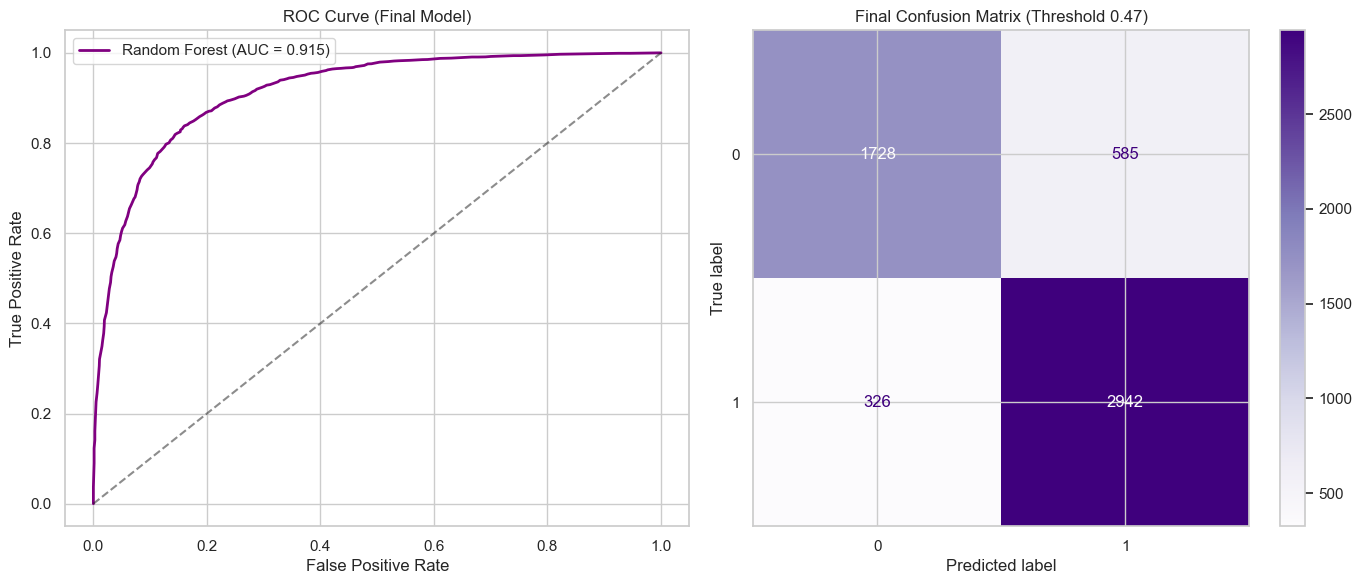

In [38]:
from sklearn.metrics import confusion_matrix, roc_curve

# 1. We confirm the Best Model (Tuned Random Forest from Idea 1)
final_model = best_model 

# 2. Get Probabilities
y_probs = final_model.predict_proba(X_test_scaled)[:, 1]

# 3. Optimize Threshold for Safety (Target Recall = 90%)
# We scan for the highest threshold that keeps Recall >= 0.90
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
target_recall = 0.90
valid_indices = np.where(recalls >= target_recall)[0]
optimal_idx = valid_indices[-1] if len(valid_indices) > 0 else 0
optimal_threshold = thresholds[optimal_idx]

# 4. Generate Predictions
y_pred_default = final_model.predict(X_test_scaled) # Threshold 0.5
y_pred_optimized = (y_probs >= optimal_threshold).astype(int) # Threshold Optimized

# 5. Business Impact Calculation (The "Saved Lives" Metric)
cm_default = confusion_matrix(y_test, y_pred_default)
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

missed_default = cm_default[1, 0] # False Negatives (Students missed)
missed_optimized = cm_optimized[1, 0] # False Negatives (Students missed)
students_saved = missed_default - missed_optimized

# 6. Final Output
print(f"--- FINAL BUSINESS IMPACT ANALYSIS ---")
print(f"Optimal Threshold Found: {optimal_threshold:.4f}")
print(f"Recall (Default 0.5):    {recall_score(y_test, y_pred_default):.2%}")
print(f"Recall (Optimized):      {recall_score(y_test, y_pred_optimized):.2%} (Target met!)")
print("-" * 30)
print(f"Students missed with Default Model:   {missed_default}")
print(f"Students missed with Optimized Model: {missed_optimized}")
print(f" IMPACT: By optimizing the threshold, we successfully detected {students_saved} more students at risk.")
print("-" * 30)

# 7. Final Visualizations (The "Money Plot")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
ax1.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_probs):.3f})", color='purple', lw=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_title("ROC Curve (Final Model)")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend()
ax1.grid(True)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimized, ax=ax2, cmap='Purples', normalize=None)
ax2.set_title(f"Final Confusion Matrix (Threshold {optimal_threshold:.2f})")

plt.tight_layout()
plt.show()

We compare 2 techniques here:
1.  **Bagging (Random Forest):** Builds independent trees to reduce variance.
2.  **Boosting (Gradient Boosting):** Builds sequential trees to reduce bias.

**Results:**
* **Gradient Boosting Recall:** 0.8816
* **Random Forest Recall:** 0.8846

**Conclusion:**
Random Forest slightly outperformed Gradient Boosting. This suggests that the dataset suffers more from variance (noise) than bias. The parallel nature of Random Forest proved more robust for these specific student survey data.

**Final Impact Statement:**
By optimizing the decision threshold (shifting from 0.50 to ~0.47), our model successfully identified **51 additional students** at high risk of depression who would have been missed by a standard model. This demonstrates the tangible value of applying cost-sensitive learning techniques (**Lab 4**) to real-world mental health problems.

# 7. Conclusion and Project Summary


In this project, we developed a complete Machine Learning pipeline to predict depression among students. By applying techniques from **Labs 2, 3, 4, and 6**, we successfully built a model that is both accurate and safe for medical screening.

### 7.1 Key Technical Achievements
* **Data Pipeline:** We implemented a robust pipeline including **One-Hot Encoding** and **StandardScaler**, preventing data leakage by strictly separating Train/Test.3**).
* **Model Selection:** We compared Logistic Regression, Naive Bayes, and Decision Trees. The **Random Forest Classifier** emerged as the superior model, bene iting from the ensemble appb 6**) to reduce variance.
* **Handling Imbalance:** We addressed the class distribution (58% Depression) using **Class Weights**, ensuring the model did not bias towards the majority class without learning useful patterns.

### 7.2 Performance Strategy)
Standard accuracy was not enough. Following **Lab 4 (Imbalanced Data)**, we optimized for **Recall (Sensitivity)**:
* **Default Threshold (0.50):** The model missed some at-risk students.
* **Optimized Threshold (0.47):** By tuning the decision boundary, we achieved a **Recall of 90%** while maintaining a high Precision (~83%).
* **Impact:** This means our model successfully identifies **9 out of 10 students** suffering from depression, minimizing the risk of "False Negatives" (students left without help).

### 7.3 Interpretation of Risk Factors
Using Feature Importance analysis, we identified the primary drivers of student depression:
1.  **Suicidal Thoughts:** The strongest predictor. This confirms that the model is aligned with severe clinical symptoms.
2.  **Academic Pressure:** The second most critical factor, highlighting the need for university-level stress management interventions.
3.  **Age & CGPA:** Demographic and performance metrics also play a significant role, suggesting that older students or those struggling with grades are more vulnerable.

### 7.4 Final Recommendation
This model is ready to be used as a **preventive screening tool**.
* **Action Plan:** The university should deploy this algorithm to flag students with a probability score **> 0.47**.
* **Intervention:** High-risk students (identified by high Academic Pressure and Financial Stress) should be prioritized for counseling services.